In [23]:
from collections import ChainMap
from configparser import ConfigParser
import logging
from math import pi as PI
import numpy
import pickle
from pathlib import Path
from pprint import pformat
import sys

In [24]:
from anglr import Angle

import matplotlib.path
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sympy import *
init_printing()



In [25]:
# from environment import *
# from ncprogram import Block, NCProgram

exec(Path("py/charconsts.py").read_text())
exec(Path("py/enumerations.py").read_text())
exec(Path("py/environment.py").read_text())
exec(Path("py/ncprogram.py").read_text())

In [47]:
class Viewer():
    """ .


    """
    def __init__(self, settings=None):
        # self.settings = settings
#         Program.__init__(self, settings)
#         Driver.__init__(self, settings)
        print("initializing viewer")
        self.settings = settings
        if not self.settings:
            self.settings = { "verbose": True, "debug": False }
        if self.settings["verbose"]:
            print()
            print("Settings:")
            print()
            print(pformat([f"{k}: {v}" for k, v in self.settings.items()]).lstrip('[').rstrip(']'))
            print()
        self.env = Environment(DEFAULT_VARS)
        # programs should be loaded from a directory located by a configuration file setting
        self.programs = list()
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d', xlim=(0, 6), ylim=(0, 6))
        # self.ax.plot([0.0, 1.0], [0.2, 0.7], 0.4)
        self.current_position = Point()
#         plt.show()
        self.current_program = NCProgram()

    def code_group(self, n):
        for k in gCodeGroups.keys():
            if n in gCodeGroups[k]:
                return gCodeGroupsDict[k]
        return None

    def make_gcodes_dict(self, gcodes):
        """
        """
        result = dict()
        result[NonModal] = list()
        for n in gcodes:
            klass = self.code_group(n)
            if klass == NonModal:
                result[NonModal].append(n)
            else:
                result.update({klass : klass(n)})
        return result

    def execute(self, blk):
        result = dict()
        # validate the block and exit on error
        # extract the `G` codes
        result = self.env["G"]
        print()
        print("Current G Code Settings:")
        print()
        pp(result)
        result[NonModal] = list()
        result.update(self.make_gcodes_dict(blk.pop_G_codes()))
        result = { "G" : result }
        print()
        print("New G Code Settings:")
        print()
        pp(result)
        print()
        # process the `G` codes
        # extract the `M` code
#         result.update({"G" : self.make_gcodes_dict(gcodes)})
        result.update(blk.execute())
        print("New Result Environment:")
        print()
        pp(result)
        print()
        self.env = self.env.new_child(result)
        if "O" in self.env.maps[-1]:
            self.load_program(self.env.maps[-1]["O"])
        self.move()
        if blk.mCode():
            pass
            # process the `M` code

    def load_program(self, n):
        """ Find the given number after 'O' and followed by an up-to-5-digit
            number, the last of which match `n` as the first line of a file in
            the `gcode` directory designated in `config.ini`.
        """


#     def run(self):
#         print("Running `ncview` ...")
#         if self.settings["verbose"]:
#             print(sys.version)
#         # self.get_input()
#         self.process_args()


#         self.cmdloop()

    def process_file(self, path):
        """There should be at most one filename given on the command line.
           Since we're processing a file, it has to have been on the command line,
           and so this function has to have been called from `Program.init`.
           `path` should be a Python 3.5+ `Path`, having been converted by
           `Program.process_fname`.
        """
        # DEPRECATED
        # self.programs.append(NCProgram(path.read_text().split('\n')))
        VERBOSE = self.settings['verbose']
        if VERBOSE:
            print(f"processing file: {path=}")
        with path.open() as f:
            self.current_program.extend([Block(line) for line in f])


#     def process_args(self):
#         super().process_args()
#         # for p in self.programs:
#         #     p.run()

    def is_valid_gcode(self, s):
        try:
            b = Block(s)
        except ValueError:
            return False
        return True

#     def default(self, args):
#         if self.is_valid_gcode(args): self.execute(Block(args))
#         else:
#             super.default(args)
#         # self.ax.plot([1.0, 3.0], [0.2, 0.7], 0.4)

#     def emptyline(self):
#         pass


    def do_step(self, args):
        if self.current_program:
            self.env = self.env.new_child(self.current_program.step())
            if self.current_program.state != NCProgram.State.END:
                if self.move():
                    return False
        else:
            print("ERROR: step: No program is loaded.")
            return False

    def move(self):
        P = self.current_position
        if self.settings["verbose"]:
            print("Current position:", P)
        cur_map = self.env.maps[0]
        INCREMENTAL = self.env["G"][PositionMode] == PositionMode.INCREMENTAL
        Q = Point(*[cur_map["X"] if "X" in cur_map.keys() else (0.0 if INCREMENTAL else self.env["X"]),
                    cur_map["Y"] if "Y" in cur_map.keys() else (0.0 if INCREMENTAL else self.env["Y"]),
                    cur_map["Z"] if "Z" in cur_map.keys() else (0.0 if INCREMENTAL else self.env["Z"])
                   ])
        if self.settings["verbose"]:
            print("X, Y, Z:", Q)
        if self.env["G"][PositionMode] == PositionMode.INCREMENTAL:
            Q = P + Q
        if P != Q:
            if self.settings["verbose"]: print("Moving the tool...")
            if self.settings["verbose"]: print("Motion mode:", self.env["G"][MotionMode])
            if self.env["G"][MotionMode] in { MotionMode.RAPID, MotionMode.LINEAR }:
                if self.settings["verbose"]: print("Motion mode:", self.env["G"][MotionMode])
                self.ax.plot([P.x, Q.x], [P.y, Q.y], [P.z, Q.z])
            elif self.env["G"][MotionMode] in { MotionMode.CLOCKWISE, MotionMode.COUNTER }:
                # Draw an arc of some sort.
                if self.settings["verbose"]:
                    print("Drawing an arc...")
                V = Point ( cur_map["I"] if "I" in cur_map.keys() else 0.0,
                            cur_map["J"] if "J" in cur_map.keys() else 0.0,
                            cur_map["K"] if "K" in cur_map.keys() else 0.0
                          )
                if self.settings["verbose"]:
                    print(V)
                K = {"I", "J", "K"}
                if K.intersection(cur_map.keys()):
                    C = P + V
                elif "R" in cur_map.keys():
                    C = self.find_arc_center(P, Q, cur_map["R"])
                if self.settings['verbose']:
                    print("Arc center:", C.evalf())
                R = cur_map["R"] if "R" in cur_map.keys() else abs(V)
                if self.settings["verbose"]:
                    print("R:", R)
                P1 = P.translate(*-C)
                P2 = Q.translate(*-C)
                if self.settings["verbose"]:
                    print("P1:", P1)
                    print("P2:", P2)
                YZ_PLANE = self.env["G"][CircularPlane] == CircularPlane.YZ
                XY_PLANE = self.env["G"][CircularPlane] == CircularPlane.XY
                if self.settings["verbose"]:
                    print( CircularPlane.XY if XY_PLANE
                               else ( CircularPlane.YZ if YZ_PLANE
                                          else CircularPlane.XZ
                                    ))
                x = P1.y if YZ_PLANE else P1.x
                y = P1.y if XY_PLANE else P1.z
                if self.settings["verbose"]:
                    print(f"(x, y): ({x, y})")
                t1 = Angle(atan(y / x).evalf())
                if self.settings["verbose"]:
                    print("t1:", t1)
                x = P2.y if YZ_PLANE else P2.x
                y = P2.y if XY_PLANE else P2.z
                t2 = Angle(atan(y / x).evalf())
                if self.settings["verbose"]:
                    print("t2:", t2)
                if t2 < t1:
                    t1, t2 = t2, t1
                    if self.settings["verbose"]:
                        print(f"t1: {t1}\nt2: {t2}")
                step = t1.degrees - t2.degrees / 10
                p = matplotlib.path.Path.arc(t1.degrees, t2.degrees, n=10).vertices
                if self.settings["verbose"]:
                    print("Path Vertices:")
                    print("--------------")
                    print(p)
                p = p.transpose()
                for point in p:
                    if Angle(atan(point[1]/point[1])) > t2:
                        del(point)
                if self.settings["verbose"]:
                    print()
                    print(type(p))
                # p[0] = [x + C.x for x in p[0]]
                # p[1] = [x + C.y for x in p[1]]
                if self.settings["verbose"]:
                    print()
                    print("ARC:")
                    print(p)
                    print()
                # p[0] = [x + C.x for x in p[0]]
                # p[1] = [x + C.x for x in p[1]]
                if YZ_PLANE:
                    x = numpy.full(len(p[0]), P.x)
                    y = p[0]
                    z = p[1]
                elif XY_PLANE:
                    x = p[0]
                    y = p[1]
                    z = numpy.full(len(p[0]), P.z)
                else:
                    x = p[0]
                    y = numpy.full(len(p[0]), P.y)
                    z = p[1]
                if self.settings["verbose"]:
                    print("x:", x)
                    print("y:", y)
                    print("z:", z)
                    print()
                x = R * x + C.x
                y = R * y + C.y
                z = R * z + C.z
                self.ax.plot(x, y, z)


            else:
                raise ValueError("Motion Mode is out of range!")

        else: # check for moves that don't require `X`, `Y` or `Z`

            # circular mill `G12`, `G13`
            pass

        self.current_position = Q
        return True

    def find_arc_center(self, P0, P, R0):
        if self.settings["verbose"]:
            print("Finding the arc center...")
        x, y, z, X, X0, Y, Y0, Z, Z0, R = symbols("x y z X X0 Y Y0 Z Z0 R")
        e1 = (x-X0)**2 + (y-Y0)**2
        e2 = (x-X)**2 + (y-Y)**2
        xa = (X - X0) / 2
        ya = (Y - Y0) / 2
        x0, y0 = X0 + xa, Y0 + ya
        a = sqrt(xa**2 + ya**2)
        b = sqrt(R**2 - a**2)
        x3 = x0 + b * ya / a
        x4 = x0 - b * ya / a
        y3 = y0 - b * xa / a
        y4 = y0 + b * xa / a
        if self.settings["verbose"]:
            print()
            print("x3:")
            print(x3)
            print()
            print(y3)
            print()
            print("x4:")
            print(x4)
            print("y3:")
            print()
            print("y4:")
            print(y4)
            print()

        YZ_PLANE = self.env["G"][CircularPlane] == CircularPlane.YZ
        XY_PLANE = self.env["G"][CircularPlane] == CircularPlane.XY
        params = dict(zip([X0, Y0, X, Y, R],
                          [ P0.y if YZ_PLANE else P0.x,
                            P0.y if XY_PLANE else P0.z,
                            P.y if YZ_PLANE else P.x,
                            P.y if XY_PLANE else P.z,
                            R0
                          ]))
        if self.settings["verbose"]:
            print("Parameters: ", params)
        x3 = x3.subs(params)
        y3 = y3.subs(params)
        x4 = x4.subs(params)
        y4 = y4.subs(params)

        if self.settings["verbose"]:
            print("x3:", x3)
            print("y3:", y3)
            print("x4:", x4)
            print("y4:", y4)

        args1 = [-x3, -y3]
        args2 = [ 1/params[R]] * 3
        Q0 = Point(params[X0], params[Y0], 0).translate(*args1).evalf()
        Q = Point(params[X], params[Y], 0).translate(*args1).evalf()
        theta1 = Angle(atan(Q0.y / Q0.x))
        theta2 = Angle(atan(Q.y / Q.x))
        abc = theta1.angle_between_clockwise(theta2)
        if self.settings["verbose"]:
            print("Q0:", Q0)
            print("Q:", Q)
            print("theta1:", theta1)
            print("theta2:", theta2)
            print("abc", abc)
        if abc.radians > PI and self.env["G"][MotionMode] == MotionMode.CLOCKWISE:
            rx, ry = x3, y3
        else:
            rx, ry = x4, y4
        if XY_PLANE:
            return Point(rx, ry, P0.z)
        elif XZ_PLANE:
            return Point(rx, P0.y, ry)
        else:
            return Point(P0.x, xr, ry)


    def do_run(self):
        while self.current_program.state != NCProgram.State.END and self.do_step(None):
            pass



initializing viewer

Settings:

'verbose: True', 'debug: False'



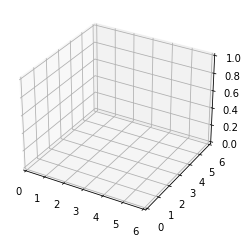

In [48]:
viewer = Viewer()

In [45]:
viewer.process_file(Path('../../data/gcode/00001.gcode'))

processing file: path=WindowsPath('../../data/gcode/00001.gcode')


In [46]:
viewer.do_run()

Executing block:  G90 G80 G40 G17 G0;
Current position: Point3D(0, 0, 0)
X, Y, Z: Point3D(0, 0, 0)
